# FogNet XAI Analysis

The purpose of this notebook is to investigate the results of XAI methods that have been applied to [FogNet](https://gridftp.tamucc.edu/fognet/): a multiscale 3D CNN with double-branch dense block and attention mechanism for fog prediction. 

XAI methods have already been applied. This notebook is used to visualize and otherwise investigate and compare their results. 

**Feature Effect Methods**

- SHAP
- Channel-wise PartitionSHAP (CwPS)

**Feature Importance Methods**

- Permutation Feature Importance (PFI)
- Group Hold Out Refitting (GFO)
- LossSHAP

# Setup

## Options

In [1]:
# Will download the FogNet XAI data from remote source
download_data = True

# Which skill metric to based PFI results
pfi_metric = "pss"
# For Group-Hold-Out, which metric was used for optimizing the threshold
opti_metric = "pss"

## Import packages

In [2]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.colors as clr
import seaborn as sns

## Definitions

In [3]:
shapGroupsFile = "xai_groupwise_shap.csv"             # SHAP applied to groups
lossshapGroupsFile = "xai_groupwise_lossshap.csv"     # LossSHAP applied to groups
groupsFile = "xai_groupwise_pfi-gho-ls.csv"           # PFI, GHO applied to groups
channelsFile = "xai_channelwise_pfi.csv"              # PFI applied to channels
cwpfiFile = "xia_channelwisesuperpixels-8x8_pfi.npz"  # PFI applied to 8x8 CwSPs 


# Define methods
methods = ["PFI",   # Permutation Feature Importance
           "GHO",   # Group Hold Out
           "LS"]    # LossSHAP

# Define groups
groups = ["G1",     # Wind
          "G2",     # Turbulence Kinetic Energy & Humidity
          "G3",     # Lower Atmospheric Thermodynamic Profile
          "G4",     # Surface Atmospheric Moisture & Microphysics
          "G5"]     # Sea Surface Temperature

# Define color map
colors = [
          ("#6b7f9f"),
          ("#b19172"),
          ("#628254"),
          ("#ab7171"),
          ("#877d9f"),
          ("#a4c2f4"),
]

# Define group sizes
groupSizes = [108, 96, 108, 60, 12]

# Trained model means (would be better to not be hard-coded, but alas)
score_means = {
    "pss" : 0.55,
    "hss" : 0.52,
    "css" : 0.50,
    }

## Download XAI results

In [4]:
if download_data:
 
  !rm {shapGroupsFile}
  !rm {lossshapGroupsFile}
  !rm {groupsFile}
  !rm {channelsFile}
  !rm {cwpfiFile}

  # Remote data source
  remote_dir = "https://raw.githubusercontent.com/conrad-blucher-institute/FogNet/main/inference/XAI/"

  !wget {remote_dir + shapGroupsFile}
  !wget {remote_dir + lossshapGroupsFile}
  !wget {remote_dir + groupsFile}
  !wget {remote_dir + channelsFile}
  !wget {remote_dir + cwpfiFile}

rm: cannot remove 'xai_groupwise_shap.csv': No such file or directory
rm: cannot remove 'xai_groupwise_lossshap.csv': No such file or directory
rm: cannot remove 'xai_groupwise_pfi-gho-ls.csv': No such file or directory
rm: cannot remove 'xai_channelwise_pfi.csv': No such file or directory
rm: cannot remove 'xia_channelwisesuperpixels-8x8_pfi.npz': No such file or directory
--2023-04-27 17:35:07--  https://raw.githubusercontent.com/conrad-blucher-institute/FogNet/main/inference/XAI/xai_groupwise_shap.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 303439 (296K) [text/plain]
Saving to: ‘xai_groupwise_shap.csv’

xai_groupwise_shap. 100%[===================>] 296.33K  --.-KB/s    in 0.04s   

2023-04-27 17:35:07 (7.42 MB/s) - ‘xai_groupwise_shap.csv’ saved 

## Plotting functions

In [5]:
# Plotting
plt.rcParams.update({'font.size': 16, 'font.weight' : 'bold'})

def make_channelfig(ax, xlabel, PFI, xlims=None, ylims=None):
  channels = dfChannels.index

  a = 0
  groups_ = groupSizes + [len(channels)]
  for i, g in enumerate(groups_):
    b = g + a
    ax.bar(x=channels[a:b], height=PFI[a:b],color=colors[i])
    a = b

  ax.text( 45/384.0 - 0.025, -0.05, "G1", transform=ax.transAxes)
  ax.text(150/384.0 - 0.025, -0.05, "G2", transform=ax.transAxes)
  ax.text(250/384.0 - 0.025, -0.05, "G3", transform=ax.transAxes)
  ax.text(340/384.0 - 0.025, -0.05, "G4", transform=ax.transAxes)
  ax.text(384/384.0 - 0.025, -0.05, "G5", transform=ax.transAxes)

  ax.set_xticks([], [])
  # plt.ylabel("Relative feature importance")
  if ylims != None:
    ax.set_ylim(ylims)
  if xlims != None:
    ax.set_xlim(xlims)
  ax.set_xlabel(xlabel, labelpad=20)


def make_groupfig(ax, xlabel, groupPFI):
  for i in range(len(groups)):
    ax.bar(x=groups[i], height=groupPFI[i], color=colors[i])
  ax.set_xlabel(xlabel)

# Feature Importance Methods

### Group-wise PFI, GHO, & LS

#### Load data

In [6]:
dfGroups = pd.read_csv(groupsFile)

pfi_vals = np.abs(np.array( dfGroups["permutation" + "_" + pfi_metric]))
pfi_norm = np.array(pfi_vals / np.sum(pfi_vals))
holdout_vals = np.abs(dfGroups["hold-out" + "_" + pfi_metric + "_opt-" + opti_metric])
holdOut_norm = np.array(holdout_vals / np.sum(holdout_vals))

# The values in this are WRONG
# shap_vals = np.abs(dfGroups["lossShap"])
# shap_norm = np.array(shap_vals / np.sum(shap_vals))

dfLossShap = pd.read_csv(lossshapGroupsFile)
dfLossShap.columns = map(str.lower, dfLossShap.columns)
shap_norm = dfLossShap[pfi_metric + "_relative"]

# Dataframe with normalized values
dfNorms = pd.DataFrame(
    {"group" : groups, 
     "PFI"   : pfi_norm, 
     "GHO"   : holdOut_norm, 
     "LS"    : shap_norm
     }
)

#### Plot

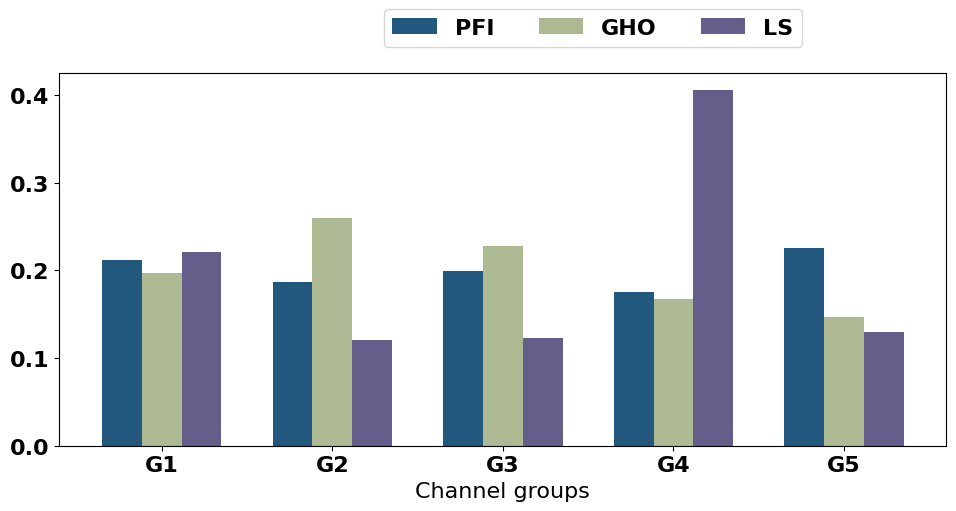

In [7]:
my_colors = ["#22577E", "#ACB992", "#655D8A"]
dfNorms.plot(x="group", kind="bar", stacked=False, figsize=(10, 5.5), color=my_colors, width = 0.7)
plt.legend(bbox_to_anchor=(0.85, 1.2), ncol=3)
plt.xticks(rotation = 0)
plt.xlabel("Channel groups")
plt.tight_layout()

## Channel-wise PFI

### Load data

In [8]:
# Load XAI output
dfChannels = pd.read_csv(channelsFile)
dfChannels.columns =  dfChannels.columns.str.lower()

dfChannels["PFI"] = score_means[pfi_metric] - dfChannels[pfi_metric + '_mean']
# dfChannels['rPFI'] = 1 - dfChannels[pfi_metric + '_mean'] / score_means[pfi_metric]
dfChannels['rPFI'] = dfChannels["PFI"] / dfChannels["PFI"].sum()

### Plot

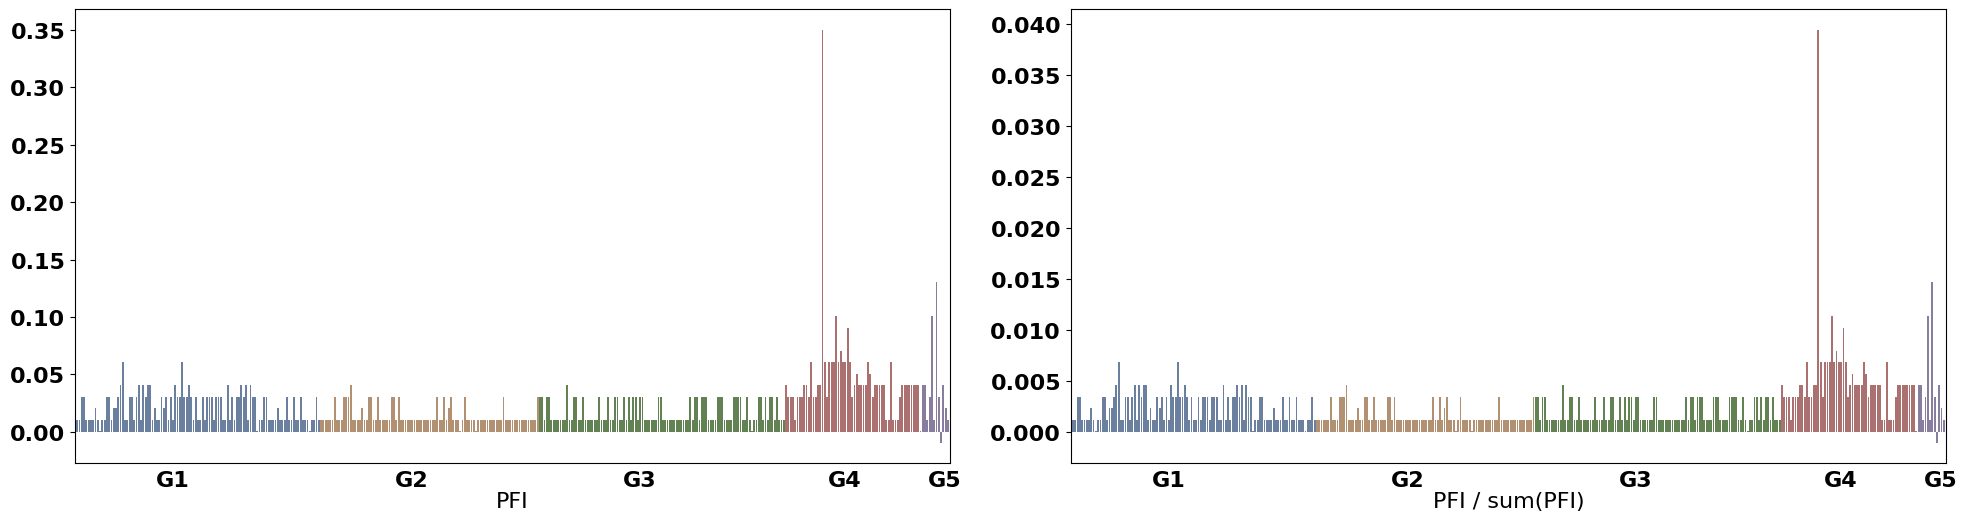

In [9]:
fig, ax = plt.subplots(1, 2, figsize=(20, 5.5))
make_channelfig(ax[0], "PFI", dfChannels['PFI'], xlims=[0,384])
make_channelfig(ax[1], "PFI / sum(PFI)", dfChannels['rPFI'], xlims=[0,384])
plt.tight_layout()

### Aggregate to groups

In [10]:
# Sum up the channels
dfChannelsAgg = dfChannels[['feature',
                            'group',
                            'PFI']].groupby("group").sum()

# Divide by group size
dfChannelsAgg['PFI_divsize'] = dfChannelsAgg['PFI'] / groupSizes

# Normalize
dfChannelsAgg['PFI_divsize_norm'] = dfChannelsAgg['PFI_divsize'] / dfChannelsAgg['PFI_divsize'].sum()

<ipython-input-10-a84f67e5e1cb>:4: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  'PFI']].groupby("group").sum()


### Plot

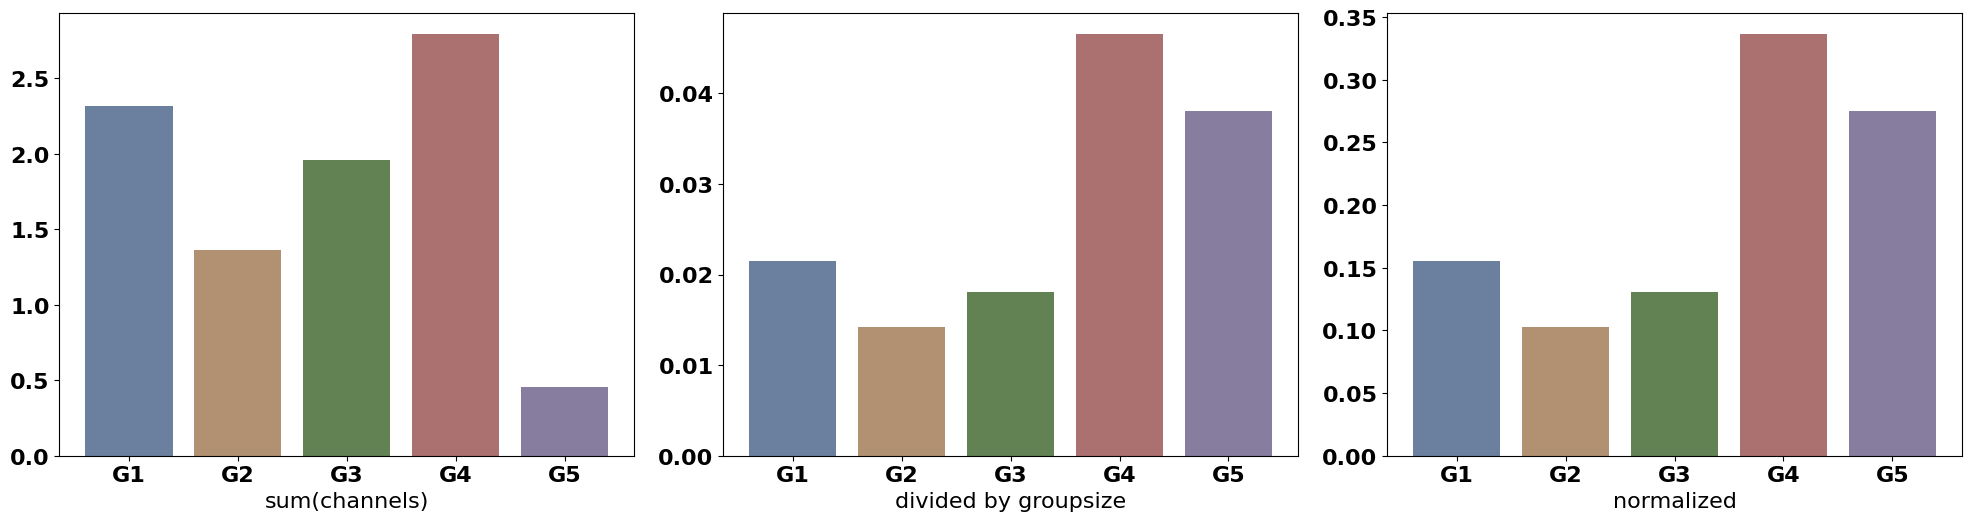

In [11]:
fig, ax = plt.subplots(1, 3, figsize=(20, 5.5))
make_groupfig(ax[0], "sum(channels)", dfChannelsAgg['PFI'])
make_groupfig(ax[1], "divided by groupsize", dfChannelsAgg['PFI_divsize'])
make_groupfig(ax[2], "normalized", dfChannelsAgg['PFI_divsize_norm'])
plt.tight_layout()

## Channel-wise SuperPixels PFI

### Load

In [12]:
cwpfi_data = np.load(cwpfiFile)
cwpfi = cwpfi_data["pfi_" + pfi_metric]
cwpfi = np.abs(cwpfi[:,:,:-1])

### Plot top N 

Text(0.5, 0.08, 'Top 15 channel-wise superpixels')

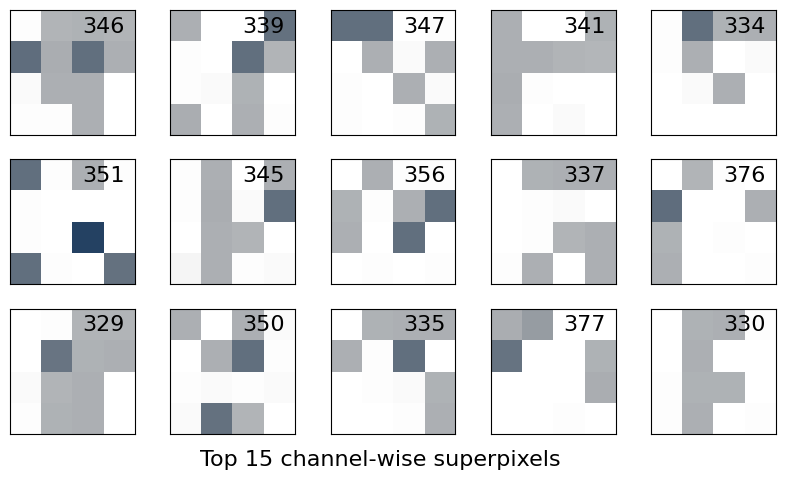

In [13]:
# Number of channel's 2D maps to plot
nPlots = 15

# Sum superpixels within each channel
cw_channels = np.sum(cwpfi, axis=(0, 1))
# Rank by sum, get the sorted indices
ranked_idx = np.argsort(cw_channels)[::-1]
# Get just the top N ranked indices
top_idx = ranked_idx[:nPlots]

# Grab the top N ranked channels
top_cwpfi = cwpfi[:,:,top_idx]

# Plot 
fig, axs = plt.subplots(3, 5, figsize=(10, 5.5))

vmax = np.max(cwpfi)
vmin = np.min(cwpfi)

cmap = clr.LinearSegmentedColormap.from_list('custom blue', [(0, 0, 0, 0), '#244162'], N=256)

idx = 0
for i in range(len(axs[0])):
  for j in range(len(axs)):
    im = axs[j, i].imshow(top_cwpfi[:,:,idx], cmap=cmap, vmax=vmax, vmin=vmin)
    axs[j, i].set_xticks([])
    axs[j, i].set_yticks([])
    axs[j, i].invert_yaxis()
    axs[j, i].set_xlabel(str(top_idx[idx]), x=0.75, labelpad=-85)
    idx += 1

fig.suptitle("Top {} channel-wise superpixels".format(nPlots), y=0.08, size="medium")

### Aggregate to channels

In [14]:
# Aggregate into channels
cw_channels = np.sum(cwpfi, axis=(0, 1))
dfChannels["cwpfi"] = cw_channels

# Normalize
pfi_norm = np.array(cw_channels / np.sum(cw_channels))
dfChannels["cwpfi_norm"] = pfi_norm

### Plot

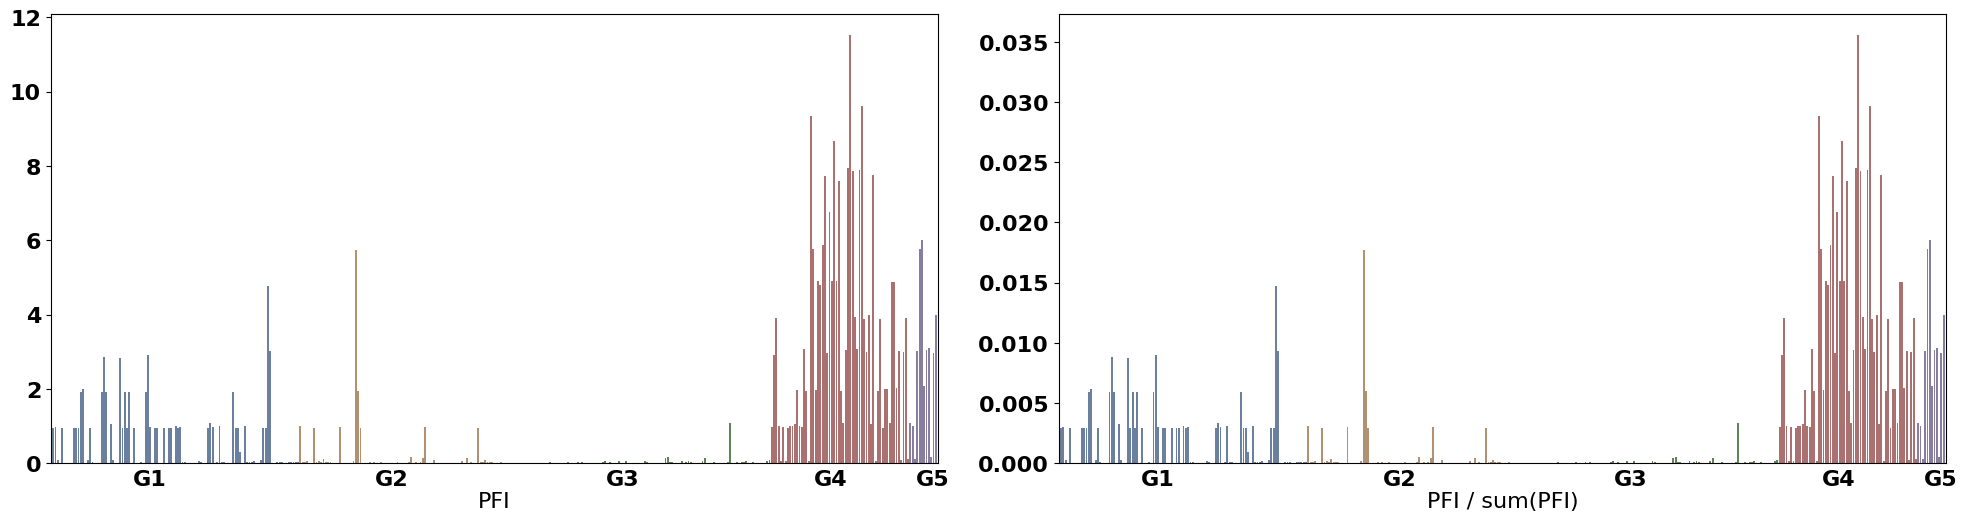

In [15]:
fig, ax = plt.subplots(1, 2, figsize=(20, 5.5))
make_channelfig(ax[0], "PFI", dfChannels["cwpfi"], xlims=[0,384])
make_channelfig(ax[1], "PFI / sum(PFI)", dfChannels["cwpfi_norm"], xlims=[0,384])
plt.tight_layout()

### Aggregate to groups

In [16]:
# Sum up the channels
dfCWPFAgg = dfChannels[['feature',
                            'group',
                            'cwpfi']].groupby("group").sum()

# Divide by group size
dfCWPFAgg['cwpfi_divsize'] = dfCWPFAgg['cwpfi'] / groupSizes

# Normalize
dfCWPFAgg['cwpfi_divsize_norm'] = dfCWPFAgg['cwpfi_divsize'] / dfCWPFAgg['cwpfi_divsize'].sum()

<ipython-input-16-82a4a4cce3a4>:4: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  'cwpfi']].groupby("group").sum()


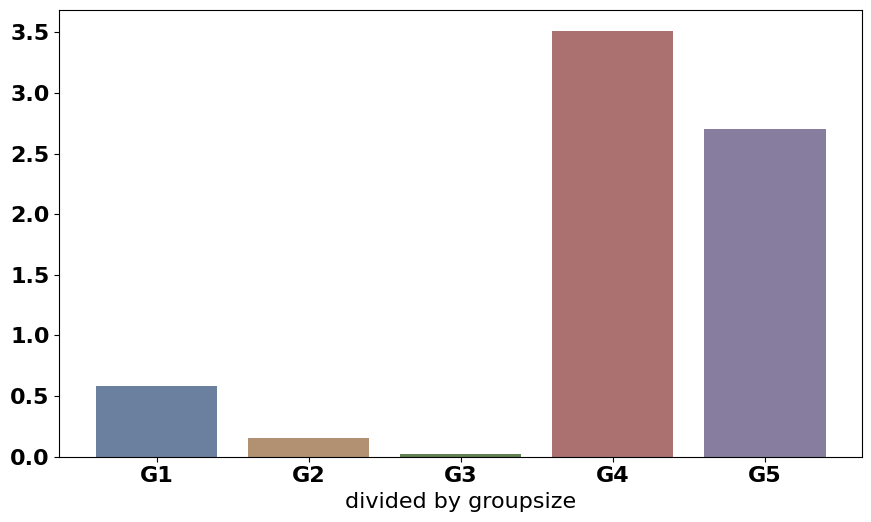

In [17]:
fig, ax = plt.subplots(1, 1, figsize=(9, 5.5))
# make_channelfig(ax, "PFI", dfChannels["cwpfi"], xlims=[0,384])
make_groupfig(ax, "divided by groupsize", dfCWPFAgg['cwpfi_divsize'])
plt.tight_layout()


# Write
plt.savefig("FogNet_XAI_FeatureImportance_CwSPsumsum_pss.pdf")

### Plot

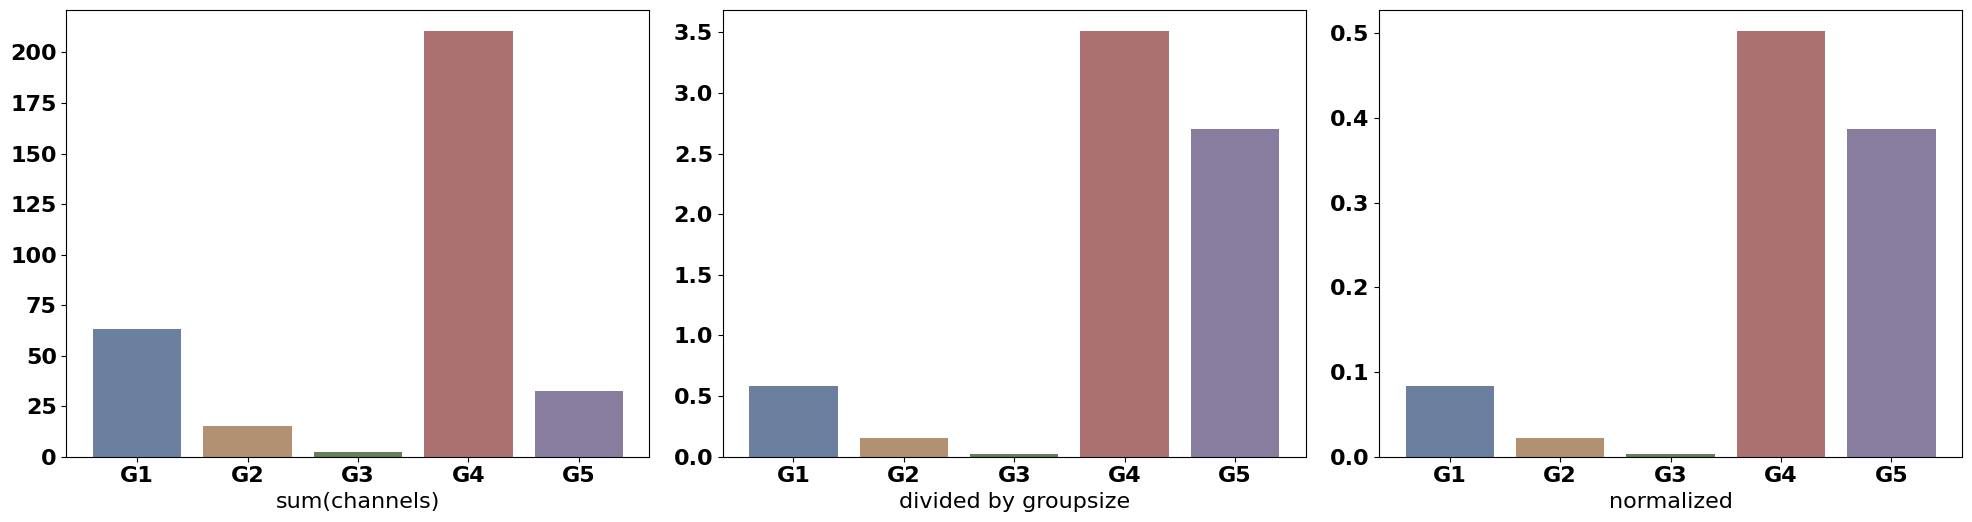

In [18]:
fig, ax = plt.subplots(1, 3, figsize=(20, 5.5))
make_groupfig(ax[0], "sum(channels)", dfCWPFAgg['cwpfi'])
make_groupfig(ax[1], "divided by groupsize", dfCWPFAgg['cwpfi_divsize'])
make_groupfig(ax[2], "normalized", dfCWPFAgg['cwpfi_divsize_norm'])
plt.tight_layout()

## Summary

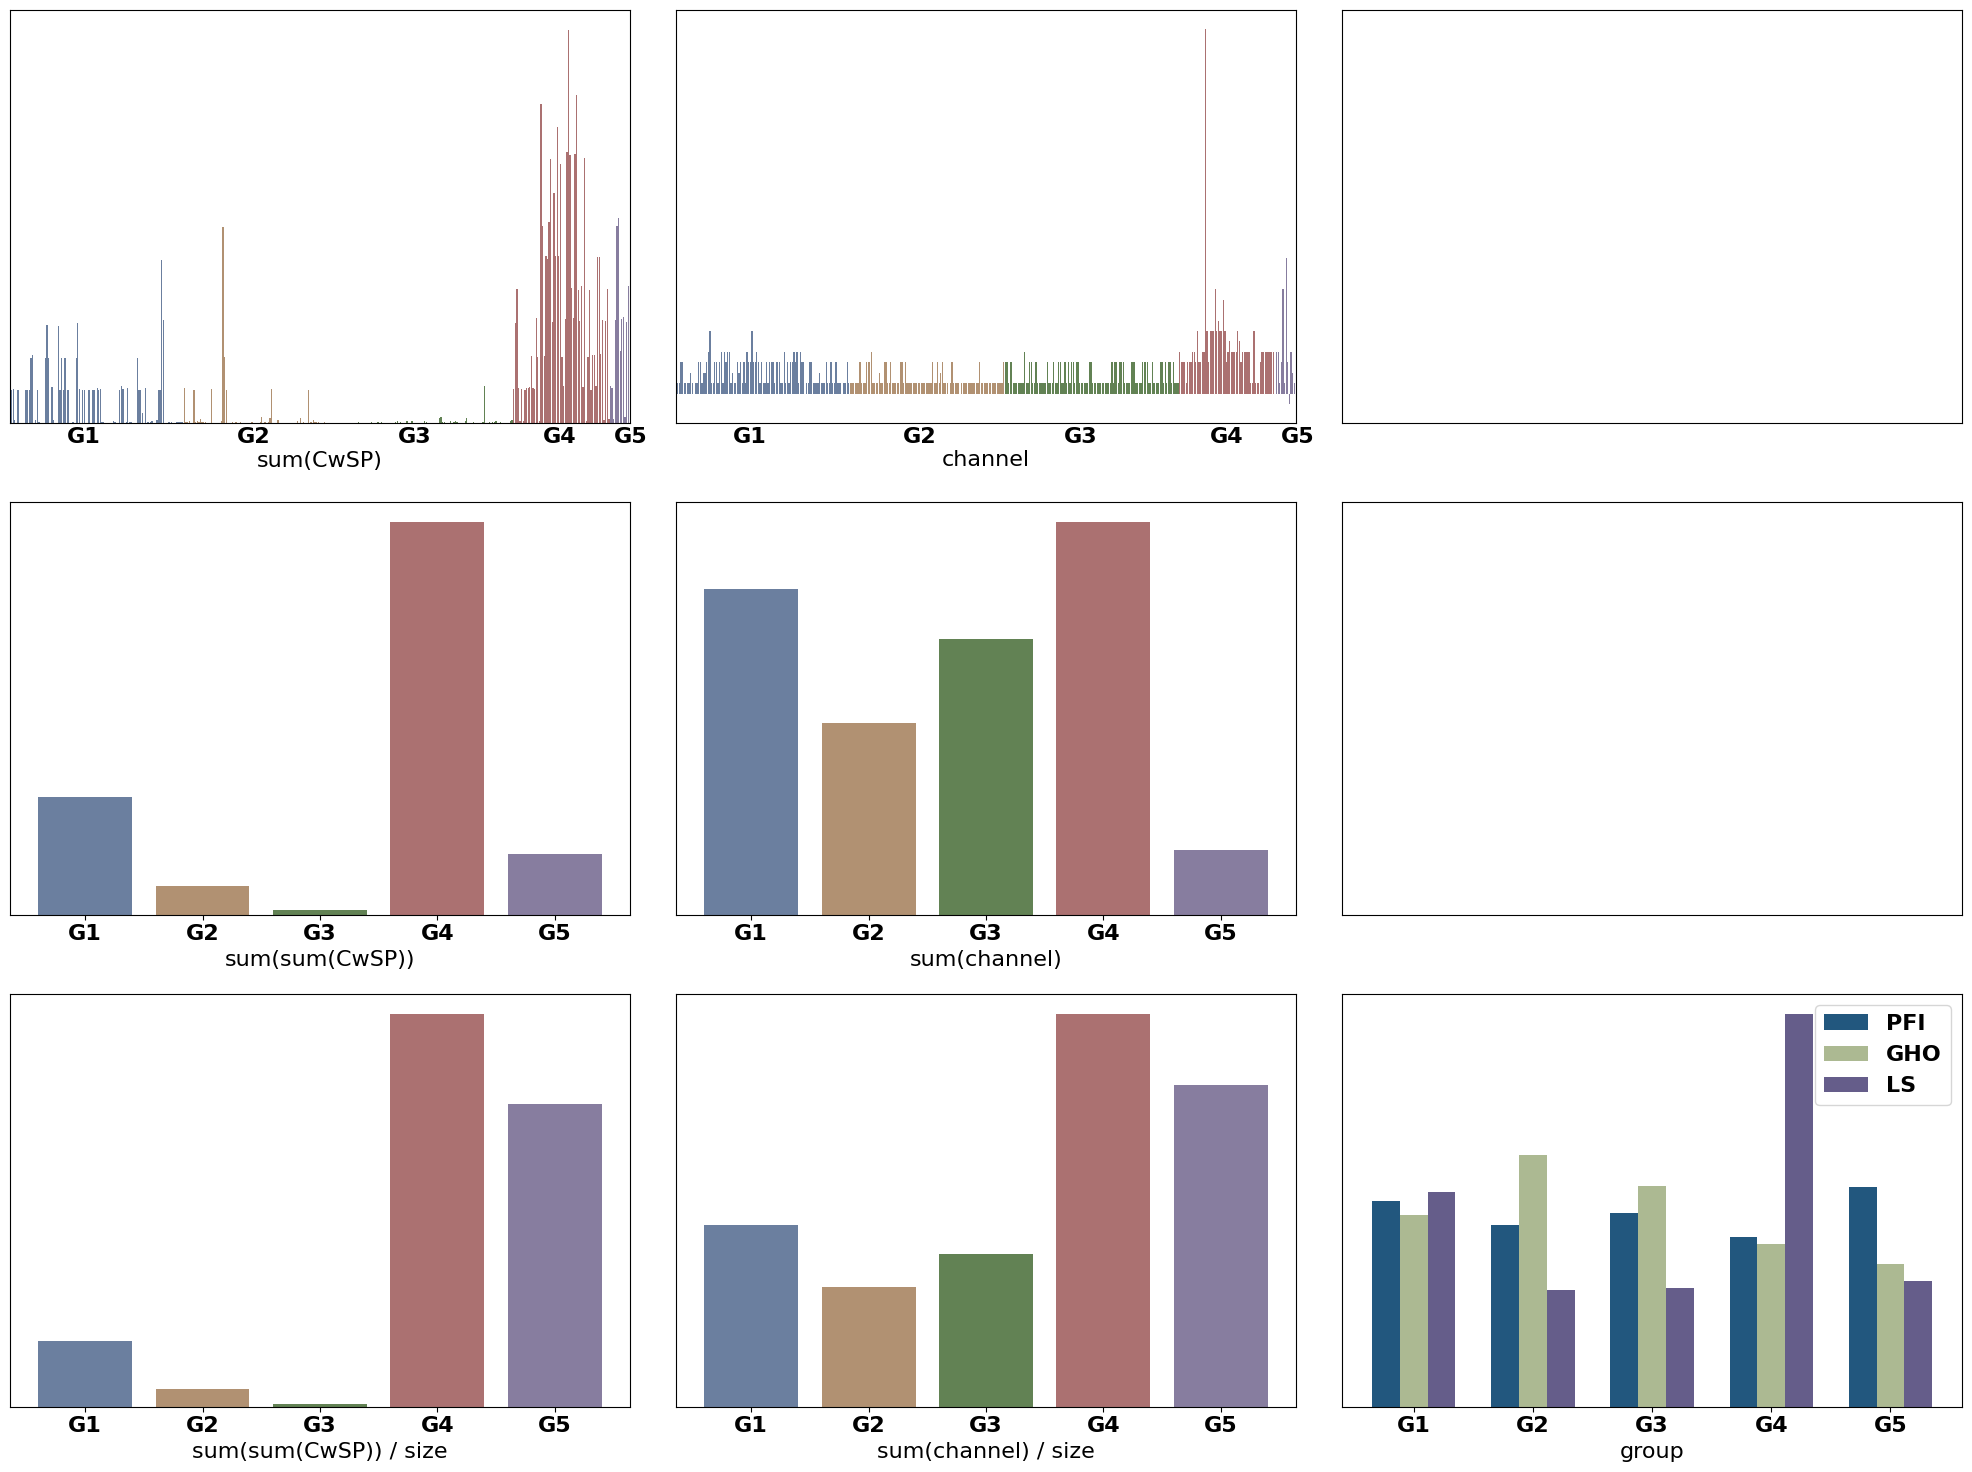

In [19]:
fig, ax = plt.subplots(3, 3, figsize=(20, 15))

ax[0][2].set_xticks([],[])
ax[1][2].set_xticks([],[])

make_channelfig(ax[0][0], "sum(CwSP)", dfChannels["cwpfi_norm"], xlims=[0,384])
make_groupfig(ax[1][0], "sum(sum(CwSP))", dfCWPFAgg['cwpfi'])
make_groupfig(ax[2][0], "sum(sum(CwSP)) / size", dfCWPFAgg['cwpfi_divsize_norm'])
make_channelfig(ax[0][1], "channel", dfChannels['rPFI'], xlims=[0,384])
make_groupfig(ax[1][1], "sum(channel)", dfChannelsAgg['PFI'])
make_groupfig(ax[2][1], "sum(channel) / size", dfChannelsAgg['PFI_divsize_norm'])
dfNorms.plot(x="group", kind="bar", stacked=False, color=my_colors, width = 0.7, ax=ax[2][2])
ax[2][2].tick_params(axis='x', labelrotation = 0)

for i in range(len(ax)):
  for j in range(len(ax[0])):
    ax[i,j].set_yticks([],[])

plt.tight_layout()

# Feature Effect Methods

## Group-wise SHAP

### Load

In [20]:
dfOutcomes = pd.read_csv(shapGroupsFile)

# melted dataset for using seaborn
df = pd.melt(dfOutcomes, 
             col_level=0, 
             id_vars=['outcome', 'pred_fog'], 
             value_vars=['G1','G2', 'G3', 'G4', 'G5'])

### Plot

**SHAP value distributions by outcome, group**

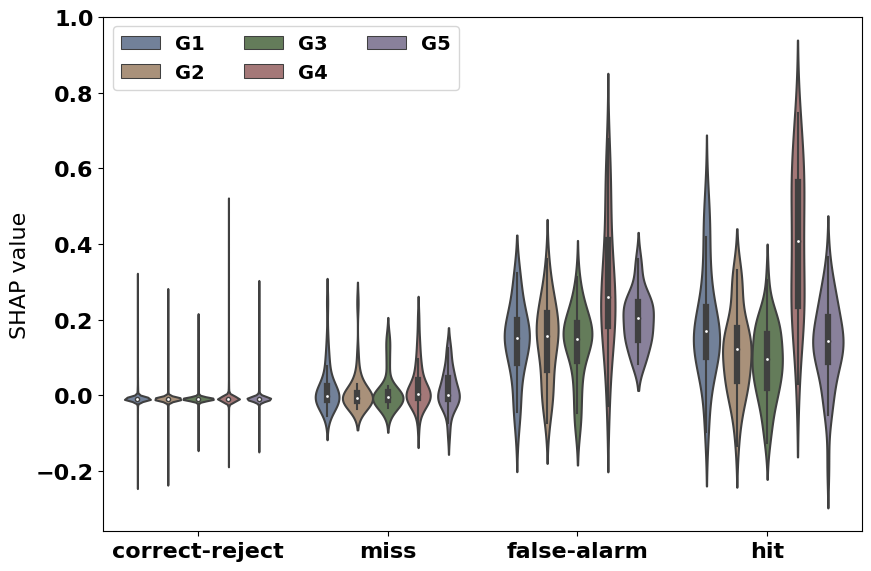

In [24]:
fig, ax = plt.subplots(figsize=(9, 6))
sns.violinplot(data=df, y='value', x='outcome', hue='variable', palette=colors, ax=ax).set(title='SHAP Value Distributions by outcome, group')
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles=handles[0:], labels=labels[0:])
plt.ylabel("SHAP value")
plt.xlabel("")
plt.legend(ncol=3, loc='upper left', prop={'size': 14})
plt.title("")
plt.tight_layout()
plt.savefig("GroupWiseSHAP_OutcomeGroup.pdf")

**SHAP value distributions by group**

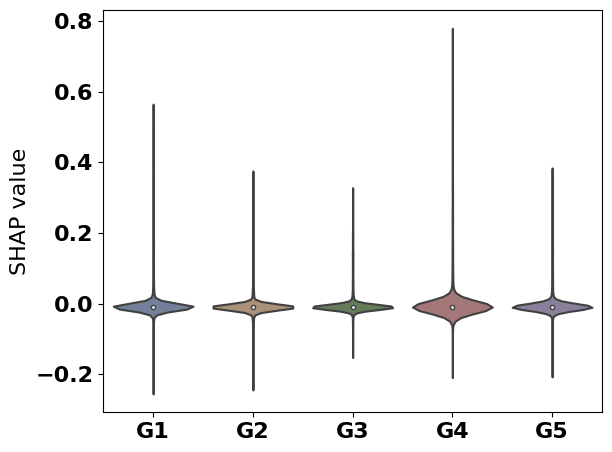

In [25]:
sns.violinplot(data=df, y='value', x='variable', scale="width", palette=colors).set(title='SHAP Value Distributions by group');
plt.ylabel("SHAP value")
plt.xlabel("")
plt.title("")
plt.tight_layout()
plt.savefig("GroupWiseSHAP_Group.pdf")